# Inference of parameters (SEAI5R model)
In this notebook, we consider the SEAI5R model with various stages of infection: exposed, activated, asymptomatic infected, symptomatic infected, hospitalised, critial and mortality. We are trying to infer the following parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)
* $\mathrm{hh}$ (rate of infected -> hospitalised)

when given full data of all the classes from a generated trajectory.
This notebook uses the experimental support for inferring age-dependent rates (as a scale factor for $\alpha$ and independent rates for $\text{hh}$).

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = np.array([0.2, 0.3])   # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_traj.npy', data_array)

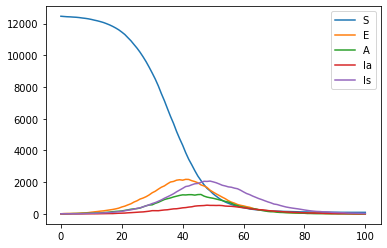

In [4]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

## 2) Inference
We take the first $40$ data points of the trajectory and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 40 
Nf_inference = Tf_inference + 1 

x = np.load('SEAI5R_traj.npy').astype('float')
x = x[:Nf_inference,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-5717.490295645444
1.7033052444458008


In [6]:
eps = 1e-4 

# Infer a scaling parameter for alpha.
alpha_g = 0.95 * alpha       
alpha_std = 0.2
alpha_b = (0.5, 1.5)

beta_g  = 0.1        
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.3
gE_std = 0.1
gE_b = (eps, 1)

gA_g    = 0.3 
gA_std = 0.1
gA_b = (eps, 1)

# Infer the rete for each age group independently
hh_g = np.array([0.11, 0.09])
hh_std = np.array([0.04, 0.04])
hh_b = (eps, 0.3)

keys = ['alpha', 'beta', 'gIa', 'gIs', 'gE', 'gA', 'hh']  

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp) 

bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, hh_b])                
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, hh_g])             
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, hh_std]) 
infer_scale_parameter = [True, False]
            
start_time = time.time()
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, infer_scale_parameter=infer_scale_parameter,
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=2512569910, Thu May 14 17:29:49 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.274656260261217e+03 1.0e+00 9.55e-01  4e-02  2e-01 0:32.4
    2     32 -3.925225495410452e+03 1.3e+00 9.44e-01  4e-02  2e-01 1:06.2
    3     48 -1.681628480440067e+03 1.5e+00 9.26e-01  4e-02  2e-01 1:52.1
    4     64 -1.323778202010728e+03 1.6e+00 9.88e-01  4e-02  2e-01 2:36.5
    5     80 -3.527064450359042e+03 1.7e+00 1.01e+00  4e-02  2e-01 3:16.3
    6     96 -3.851427405015021e+03 1.8e+00 9.23e-01  4e-02  2e-01 3:57.2
    7    112 -3.169075117312629e+03 1.8e+00 8.02e-01  3e-02  1e-01 4:37.2
    8    128 -5.338277899975510e+03 1.8e+00 8.30e-01  3e-02  1e-01 5:22.9
    9    144 -4.470185744078109e+03 1.9e+00 8.16e-01  3e-02  1e-01 5:59.1
   10    160 -2.535396287925111e+03 1.9e+00 7.51e-01  3e-02  1e-01 6:36.8
   11    176 -3.180823170844877e+03 1.9e+00 8.16e-01  3e-02  

In [7]:
# save the parameters 
np.save('SEAI5R_param.npy', params)

In [8]:
print('True parameters')
print(parameters)

best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

True parameters
{'alpha': array([0.2, 0.3]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'gE': 0.2, 'gA': 0.3333333333333333, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1]), 'cc': array([0.05, 0.05]), 'mm': array([0.4, 0.4])}

 Best estimates
{'alpha': array([0.17280578, 0.25920866]), 'beta': 0.01962132871268976, 'gIa': 0.136840448661308, 'gIs': 0.13971668433663859, 'gE': 0.2035241630188767, 'gA': 0.34755225201665235, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.06011099, 0.090868  ]), 'cc': array([0.05, 0.05]), 'mm': array([0.4, 0.4])}


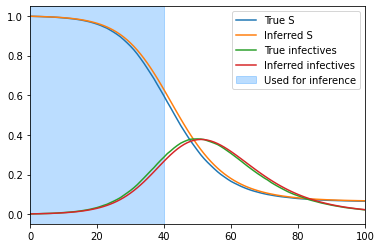

In [9]:
x0 = x[0] 
det_model = pyross.deterministic.SEAI5R(best_estimates, int(M), fi)
estimator.set_params(best_estimates)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('SEAI5R_traj.npy').astype('float')[:, :8*M]/N

plt.plot(np.sum(x[:,0:M], axis=1), label='True S')
plt.plot(np.sum(x_det[:,0:M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:,M:], axis=1), label='True infectives')
plt.plot(np.sum(x_det[:, M:], axis=1), label='Inferred infectives')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()